# <b> Deep Learning for NLP- Final Project- Question Answering </b>



# <b> Team Members<br>
### <b> Sai Suma Dodda- sdodda4@uic.edu, UIN - 672075210
### <b> Vinay Kaushik Kammara- vkamma2@uic.edu, UIN- 659954836
### <b> Manasa Kandimalla - mkandi3@uic.edu, UIN - 654992443


#Brief description of the notebook 

This notebook is written in Google Colab. At one point, you would need to mount your drive to import the model and the json files

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec  8 02:41:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mounting Google Drive 

Here we mount the google drive to import the model and json file since the size of the model file is large and takes time to upload.

---



In [ ]:
# Mounting the drive in order to import the pytorch model

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Upload data set

Please upload the json files and execute the below cell

In [ ]:
# Upload the files dev-1.1-TA.json and train-1.1-TA.json directly to colab using the upload to session storage

! mkdir data
! mv /content/dev-v1.1-TA.json data
! mv /content/train-v1.1-TA.json data

In [ ]:
# Installing Transformers module 
! pip install transformers

     |████████████████████████████████| 1.4MB 8.3MB/s 
     |████████████████████████████████| 2.9MB 29.8MB/s 
     |████████████████████████████████| 890kB 37.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cbf4f1b7a2676dc35a2e30a64b6c48f031bf8d2bc3f8e488d36a707de53efa7f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Model Initialization

Model has been declared below. <br>

For model forward function,The arguments are specified as below <br>
        
**input_ids** -- input_ids is a tensor 
            in shape (batch_size, sequence_length)<br>
**attention_mask** -- attention_mask is a tensor
            in shape (batch_size, sequence_length)<br>
**token_type_ids** -- token_type ids is a tensor
            in shape (batch_size, sequence_length)

Reference link - https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForQuestionAnswering

In [ ]:
# Declaring the model and initialising the functions

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import BertPreTrainedModel, BertModel, BertConfig

class BertForSquad(BertPreTrainedModel):
    def __init__(self, config: BertConfig):
        super().__init__(config)
        self.num_labels = config.num_labels # [0, 1] (start or end)
        self.bert = BertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels) # TODO: Not a separate FFN ? (For Start_FFN and End_FFN)
        self.init_weights()

    def forward(self,input_ids,attention_mask: torch.Tensor,token_type_ids: torch.Tensor):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            )

        sequence_output = output[0] # the last hidden state (batch, sequence_length, hidden_size)
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        outputs = (start_logits, end_logits) 

        return outputs

# Data Preprocessing and Testing functions <br>

Squad DataSet: An interface implemented for the Stanford question Answering Dataset. <br>

Squad Dataset indexing : The argument passed is the index here. Each question has a unique index. This returns id of the question which is saved in the json, corresponding context of the quesion, answer and the start position of the answer in terms of character indexing level. <br>



In [ ]:
# Dataset declaration
# This cell consists of tokenisation and data preprocessing

from typing import List, Tuple, Any, Dict, Union
from multiprocessing import Process
import json
import os
from tqdm import tqdm
from transformers import BertTokenizerFast
from tqdm import trange

# Function to remove spaces
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

class SquadExample(object):
    def __init__(
        self,
        qas_id,
        question_idx,
        question_text,
        context_text,
        answer_text,
        start_pos_char,
        title,
        answers=[],
        is_impossible=False, # Considering the non-answerable case
    ):
        self.qas_id = qas_id
        self.question_idx = question_idx
        self.question_text = question_text
        self.context_text = context_text
        self.answer_text = answer_text
        self.title = title
        self.is_impossible = is_impossible
        self.answers = answers
        self.start_pos_char = start_pos_char
        self.start_pos, self.end_pos = 0, 0

        doc_tokens = []
        char_to_word_offset = []
        prev_is_whitespace = True

def _create_sample(input_data, set_type):
    is_training = set_type == "train"
    question_idx = 0
    examples = []
    for page in tqdm(input_data): # The number of Wikipedia pages
        title = page["title"]
        for paragraph in page["paragraphs"]:
            context_text = paragraph["context"]
            for qa in paragraph["qas"]:
                qas_id = qa["id"]
                question_text = qa["question"]
                if question_idx != 0 :
                    question_idx += 1 # Assign unique index for each question
                start_pos_char = None
                answer_txt = None
                answers = []
                
                if "is_impossible" in qa:
                    is_impossible = qa["is_impossible"]
                else:
                    is_impossible = False
                
                if not is_impossible:
                    if is_training:
                        answer = qa["answers"][0]
                        answer_text = answer["text"]
                        start_pos_char = answer["answer_start"]
                    else:
                        answers = qa["answers"]

                    example = SquadExample(
                        qas_id=qas_id,
                        question_idx=question_idx,
                        question_text=question_text,
                        context_text=context_text,
                        answer_text=answer_text,
                        start_pos_char=start_pos_char,
                        title=title,
                        is_impossible=is_impossible,
                        answers=answers,
                    )
                    examples.append(example)
    print('Dataset length: ', len(examples))
    return examples               

def get_train_data(data_dir, filename=None):
    if data_dir == None:
        data_dir = ""
    with open(os.path.join(data_dir, filename if data_dir is not None else filename), "r", encoding="utf-8") as fp:
        data = json.load(fp)["data"]
        dataset = _create_sample(data, "train")
    
    return dataset

class SquadDataset(object):
    # Implementing the interface
    def __init__(self, json_file: str='data/train-v1.1-TA.json'):
        """ Squad Dataset Initializer
        You can use this part as you like.
        Load the given json file properly and provide a simple interface.
        Arguments:
        json_file -- the name of the json file which have to be processed.
        """
        
        with open(json_file) as fp:
            self.data = json.load(fp)["data"]
            print("Extracting data samples from raw SQuAD json file")
            self.dataset = get_train_data(data_dir="", filename=json_file)
        
    # Returns the length of the dataset
    def __len__(self) -> int:
        length = len(self.dataset)
        return length

    def __getitem__(self, index: int) -> Dict[str, Any]:
        """ Squad Dataset Indexing
        Arguments:
        index -- The index of the question
                 Each question should have a unique index number in the order.
        Return:
        id_str -- The id of the question, which is saved in the json file.
                  You can find it when you check the file structure.
                  This id is needed when evaluating your model.
        context -- The corresponding context of the question.
        question -- The question
        answer -- The corresponding answer of the question.
                  Just select the first answer of the answers list.
        start_pos -- The position of the answer in terms of character indexing level.
                     This information is also saved in the file in raw.
        """
        
        sample = self.dataset[index]
        id_str = sample.qas_id
        context = sample.context_text
        question = sample.question_text
        answer = sample.answer_text
        start_pos = sample.start_pos_char
        

        sample: Dict[str, Any] = {
            'id': id_str,
            'context': context,
            'question': question,
            'answer': answer,
            'start_pos': start_pos
        }

        return sample

def squad_features(
    context: str,
    question: str,
    answer: Union[str, None],
    start_char_pos: Union[int, None],
    tokenizer: BertTokenizerFast
) -> Tuple[List[int], List[int], int, int]:
    """ Squad feature extractor
    Implement the feature extractor from a Squad sample for your model
    Return values should follow [CLS + question + SEP + context + SEP] form.
    In addition, because start_char_pos is based on character index, you should convert it to proper token index.
    Check the test cases to know the functionality in detail.
    Note: input_ids and token_type_ids follows the transfomer library documentation 
    https://huggingface.co/transformers/glossary.html
    Arguments:
    context -- Context string
    question -- Question string
    answer -- Answer string. If the answer is None, return None for start_token_pos and end_token_pos
    start_char_pos -- Character index which the answer starts from in the context.
                      If the answer is None, this argument is also None.
    tokenizer -- Tokenizer to encode text strings.
                 Explanation: https://huggingface.co/transformers/model_doc/bert.html#berttokenizerfast
    Returns:
    input_ids -- Input ids
    token_type_ids -- Token type ids
    start_token_pos -- Token index which the answer starts from in the input_ids list. 
                       None if no answer is given.
    end_token_pos -- Token index which the answer ends by in the input_ids list.
                     This includes the last token which located in the index.
                     None if no answer is given.
    """
    
    encoded_dict = tokenizer.encode_plus(question, context)
    input_ids = encoded_dict["input_ids"]
    token_type_ids = encoded_dict["token_type_ids"]
    input_ids_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    if answer is None and start_char_pos is None:
        start_token_pos = None
        end_token_pos = None
        return input_ids, token_type_ids, start_token_pos, end_token_pos

    start_token_pos, end_token_pos = 0, 0
    start_token_pos += token_type_ids.count(0)
    start_token_pos += len(tokenizer.tokenize(context[:start_char_pos]))
    end_token_pos += len(tokenizer.tokenize(answer)) + start_token_pos - 1
    # Extract tokenized answer part only
    tokenized_answer = " ".join(tokenizer.convert_ids_to_tokens(input_ids[start_token_pos : end_token_pos + 1]))

    subword_prefix_original = "##" if "##" in tokenized_answer else ""
    subword_prefix = "##"
    tokenized_answer = tokenized_answer.replace('#', '')
    if tokenized_answer != answer.lower() and start_token_pos == end_token_pos and answer in tokenized_answer:

        # A single word but different subword tokenization case
        new_subword_list = [subword_prefix_original + tokenized_answer[:len(answer)], subword_prefix + tokenized_answer[len(answer):]]
        input_ids = input_ids[:start_token_pos] + tokenizer.convert_tokens_to_ids(new_subword_list) + input_ids[end_token_pos + 1 :]
        token_type_ids.append(1)
    assert len(input_ids) == len(token_type_ids)
    

    return input_ids, token_type_ids, start_token_pos, end_token_pos

    
########################################################
# Helper functions below. DO NOT MODIFY!               #
# Read helper classes to implement your code properly! #
########################################################

class SquadFeatureDataset(object):
    """ Squad Feature Dataset
    The wrapper class for the squad_feature function
    """
    def __init__(self, dataset: SquadDataset, bert_type: str, lazy=False, return_sample=False, eval=False):
        self.dataset = dataset
        self.tokenizer = BertTokenizerFast.from_pretrained(bert_type)
        self.return_sample = return_sample
        self.eval = eval

        if not lazy:
            self.lazy = True
            self.dataset = [self[index] for index in trange(0, len(self.dataset), desc="Preprocessing")]

        self.lazy = lazy

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index: int):
        if not self.lazy:
            return self.dataset[index]
        
        sample = self.dataset[index]
        context = sample['context']
        question = sample['question']
        answer = sample['answer']
        start_pos = sample['start_pos']

        if self.eval:
            out = squad_features(context, question, None, None, self.tokenizer)
        else:
            out = squad_features(context, question, answer, start_pos, self.tokenizer)

        if self.return_sample:
            out = (out, sample)

        return out

# Testing

def test_wrapper_fn(dataset):
    [dataset[sample_id]['id'] for sample_id in range(0, len(dataset))]

def test_squadDataSet(dataset):
    print("Dataset Test Cases")
    # First test
    assert len(dataset) == 87474, \
        "Dataset has some missing or duplicated samples."
    print("First test passed")

    # Second test
    expected = {
        'id': '5733be284776f41900661182',
        'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
        'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
        'answer': 'Saint Bernadette Soubirous',
        'start_pos': 515
    }
    assert dataset[0] == expected, \
        "Indexing form does not match the expected result."
    print("Second test passed")

    # Third test
    expected = {
        'id': '57302039b2c2fd14005688db', 
        'context': 'On February 29, 2012, Microsoft released Windows 8 Consumer Preview, the beta version of Windows 8, build 8250. Alongside other changes, the build removed the Start button from the taskbar for the first time since its debut on Windows 95; according to Windows manager Chaitanya Sareen, the Start button was removed to reflect their view that on Windows 8, the desktop was an "app" itself, and not the primary interface of the operating system. Windows president Steven Sinofsky said more than 100,000 changes had been made since the developer version went public. The day after its release, Windows 8 Consumer Preview had been downloaded over one million times. Like the Developer Preview, the Consumer Preview expired on January 15, 2013.', 
        'question': 'When was the beta version of Windows 8 made available to the public?', 
        'answer': 'February 29, 2012', 
        'start_pos': 3
    }
    assert dataset[80000] == expected, \
        "Indexing result does not match the expected result."
    print("Third test passed")

    result = True

    process = Process(target=test_wrapper_fn, args=(dataset,))
    process.start()
    process.join(timeout=1)

    if process.is_alive():
        process.terminate()
        process.join()
        result = False

    # Forth test
    assert result, \
        "Indexing is too slow."
    print("Forth test passed")

    # Fifth test
    assert not process.exitcode, \
        "Error while indexing the dataset."
    print("Fifth test passed")

    print("All tests passed")

def test_squadFeatureExtractor(dataset):
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    # First test
    context = 'This is a sample context. BERT will find the answer words in the context by pointing the start and end token positions.'
    question = 'Where are the answer words?'
    answer = 'in the context'
    start_pos = context.find(answer)
    input_ids, token_type_ids, start_pos, end_pos = squad_features(context, question, answer, start_pos, tokenizer)

    assert tokenizer.convert_ids_to_tokens(input_ids) == \
        ['[CLS]', 'where', 'are', 'the', 'answer', 'words', '?', '[SEP]', \
         'this', 'is', 'a', 'sample', 'context', '.', \
         'bert', 'will', 'find', 'the', 'answer', 'words', 'in', 'the', 'context', \
         'by', 'pointing', 'the', 'start', 'and', 'end', 'token', 'positions', '.', '[SEP]'], \
             "Your tokenized result does not match the expected result."

    assert token_type_ids == \
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], \
        "Sentence type ids do not math the expected result"

    assert tokenizer.convert_ids_to_tokens(input_ids[start_pos: end_pos+1]) == ['in', 'the', 'context'], \
        "The start and end tokens do not point the answer position."

    print("First test passed!")

    # Second test
    context = 'Sometimes, the answer could be subwords so you may need to split them manually.'
    question = 'What should the answer consist of'
    answer = 'word'
    start_pos = context.find(answer)
    input_ids, token_type_ids, start_pos, end_pos = squad_features(context, question, answer, start_pos, tokenizer)
    
    assert tokenizer.convert_ids_to_tokens(input_ids) == \
        ['[CLS]', 'what', 'should', 'the', 'answer', 'consist', 'of', '[SEP]',
         'sometimes', ',', 'the', 'answer', 'could', 'be', 'sub', '##word', '##s',
         'so', 'you', 'may', 'need', 'to', 'split', 'them', 'manually', '.', '[SEP]'], \
             "Your tokenized result does not match the expected result."

    assert token_type_ids == \
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], \
        "Sentence type ids do not math the expected result"

    assert tokenizer.convert_ids_to_tokens(input_ids[start_pos: end_pos+1]) == ['##word'], \
        "The start and end tokens do not point the answer position."

    print("Second test passed!")

    # Third test
    context = 'When the answer is not given, you should return None for start_pos and end_pos.'
    question = 'This test case does not need a question'
    input_ids, token_type_ids, start_pos, end_pos = squad_features(context, question, None, None, tokenizer)

    assert len(input_ids) == 33, \
        "Tokenized result does not match the expected result."
    
    assert start_pos is None and end_pos is None, \
        "Return None for start_pos and end_pos when the answer is not given."

    print("Third test passed")

    # Forth test
    sample = dataset[0]
    context = sample['context']
    question = sample['question']
    answer = sample['answer']
    start_pos = sample['start_pos']

    input_ids, token_type_ids, start_pos, end_pos = squad_features(context, question, answer, start_pos, tokenizer)

    assert len(input_ids) == 176, \
        "Tokenized result does not match the expected result."

    assert tokenizer.convert_ids_to_tokens(input_ids[start_pos: end_pos+1]) == tokenizer.tokenize(answer), \
        "The start and end tokens do not point to the answer position."

    print("Forth test passed")

    # Fifth test
    sample = dataset[80000]
    context = sample['context']
    question = sample['question']
    answer = sample['answer']
    start_pos = sample['start_pos']

    input_ids, token_type_ids, start_pos, end_pos = squad_features(context, question, answer, start_pos, tokenizer)
    
    assert len(input_ids) == 165, \
        "Tokenized result does not match the expected result."

    assert tokenizer.convert_ids_to_tokens(input_ids[start_pos: end_pos+1]) == tokenizer.tokenize(answer), \
        "The start and end tokens do not point to the answer position."

    print("Fifth test passed")

    print("All tests passed!")

def test_squadFeatureDataset(dataset):
    print("Testing")
    dataset = SquadFeatureDataset(dataset, bert_type='bert-base-uncased', lazy=True)

    input_ids, token_type_ids, start_pos, end_pos = dataset[0]
    print("input_ids:", input_ids)
    print("token_type_ids:", token_type_ids)
    print("start_pos:", start_pos)
    print("end_pos:", end_pos)

    print("The test passed!")

if __name__ == "__main__":
    dataset = SquadDataset()

    test_squadDataSet(dataset)
    test_squadFeatureExtractor(dataset)
    test_squadFeatureDataset(dataset)

Extracting data samples from raw SQuAD json file


100%|██████████| 442/442 [00:00<00:00, 576.02it/s]

Dataset length:  87474
Dataset Test Cases
First test passed
Second test passed
Third test passed


Forth test passed
Fifth test passed
All tests passed



First test passed!
Second test passed!
Third test passed
Forth test passed
Fifth test passed
All tests passed!
Testing
input_ids: [101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 

# Training Model

Below cell consists of training function for the Squad Question Answering BERT model. For our model, we have used 
<br>**5 epochs** <br>
**batch size of 10**<br>
**learning rate of 5e-5** <br> **bert type: 'bert-base-uncased'** . <br>

Initially, we have trained the model of 3 epochs with a 16GB RAM, it took close to 40 hours to complete and save the checkpoint. So in order to test for 5 epochs, it would take us days to get it trained. Hence we have bought Colab pro which offers us 26 GB RAM and T4 GPU. 
<br> 
Now with Colab Pro,we have tried for 5 epochs and it took close to 2-3 hours for training it. Hence, it is recommended to run the below cell on a colab pro account or a faster GPU.

In [ ]:
#Training the BERT model
from typing import List, Tuple
import random

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler
from torch.utils.data import DataLoader

from tqdm import tqdm, trange

def train():
    """ Training function for Squad QA BERT model
    Explanation: https://medium.com/@davidlmorton/increasing-mini-batch-size-without-increasing-memory-6794e10db672
    Useful readings: https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/ 
    """ 
    epochs = 5
    learning_rate = 5e-5
    batch_size = 10
    bert_type = 'bert-base-uncased' 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Change the lazy option if you want fast debugging.
    dataset = SquadFeatureDataset(SquadDataset(), bert_type=bert_type, lazy=False) 

    model = BertForSquad.from_pretrained(bert_type)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
    batch_sampler = SquadBucketSampler(dataset, batch_size, shuffle=True)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler, collate_fn=squad_feature_assemble)
    loss_fct = torch.nn.CrossEntropyLoss()

    model.train()
    losses = []
    for epoch in range(epochs):
        batch_loss = 0.0
        for input_ids, attention_mask, token_type_ids, start_pos, end_pos in tqdm(data_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            start_pos = start_pos.to(device)
            end_pos = end_pos.to(device)
            optimizer.zero_grad()
            start_logits, end_logits = model(input_ids, attention_mask, token_type_ids)
            start_loss = loss_fct(start_logits, start_pos)
            end_loss = loss_fct(end_logits, end_pos)
            loss = start_loss + end_loss
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
            del start_logits, end_logits, loss # MemoryError
        losses.append(batch_loss)

    # Saving the model in the checkpoint folder.
    # After the training cell is executed, you would be able to see a folder which consists of pytorch model bin file along with config.json 
    model.save_pretrained('./checkpoint')

def squad_feature_assemble(
    samples: List[Tuple[List[int], List[int], int, int]]):
    input_ids, token_type_ids, start_pos, end_pos = zip(*samples)
    attention_mask = [[1] * len(input_id) for input_id in input_ids]

    input_ids = pad_sequence([torch.Tensor(input_id).to(torch.long) for input_id in input_ids], \
                             padding_value=0, batch_first=True)
    token_type_ids = pad_sequence([torch.Tensor(token_type_id).to(torch.long) for token_type_id in token_type_ids], \
                                  padding_value=1, batch_first=True)
    attention_mask = pad_sequence([torch.Tensor(mask).to(torch.long) for mask in attention_mask], \
                                  padding_value=0, batch_first=True)

    start_pos = torch.Tensor(start_pos).to(torch.long)
    end_pos = torch.Tensor(end_pos).to(torch.long)
    
    return input_ids, attention_mask, token_type_ids, start_pos, end_pos

class SquadBucketSampler(Sampler):
    """ Squad dataset bucketed batch sampler
    squad_feature_dataset(squad_dataset, lazy=False)
    batch_sampler = SquadBucketSampler(squad_feature_dataset, batch_size, shuffle=True)
    data_loader = DataLoader(squad_feature_dataset, ..., batch_size=1, batch_sampler=batch_sampler, ...)
    """
    def __init__(self, dataset: SquadFeatureDataset, batch_size, shuffle=False):
        super().__init__(dataset)
        self.shuffle = shuffle

        _, indices = zip(*sorted((len(input_ids), index) for index, (input_ids, _, _, _) in enumerate(tqdm(dataset, desc="Bucketing"))))
        self.batched_indices = [indices[index: index+batch_size] for index in range(0, len(indices), batch_size)]

    def __len__(self):
        return len(self.batched_indices)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.batched_indices)

        for batch in self.batched_indices:
            yield batch

if __name__ == "__main__":
    train()

Extracting data sample from raw SQuAD json file... >>


100%|██████████| 442/442 [00:00<00:00, 821.68it/s]


Dataset length:  87474


Preprocessing: 100%|██████████| 87474/87474 [01:21<00:00, 1070.20it/s]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSquad: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSquad from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSquad from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSquad were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 

# Evaluation

Determining the exact match score along with the f1 score. **F1 Score** is used to measure the search, document classification performance. <br>

**Exact matching score**  compares the ground truth answer to prediction and gives us an estimated score

In [ ]:
""" Official evaluation script for v1.1 of the SQuAD dataset. """
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys

def normalize_answer(s):
    # Lower text and remove punctuation, articles and extra whitespace
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def F1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

def evaluate(dataset, predictions):
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    message = 'Unanswered question ' + qa['id'] + \
                              ' will receive score 0.'
                    print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']]
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    F1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}


# Inference

The inference function probability tensor for the start , end position and start,end indices of the context. It finds the start and end positions of the answer which maximizes
 P(start, end | context_start_pos <= start <= end <= context_end_pos) . <br>



 In the inference answer function, we find the original words in the context by the start and end token positions of the answer and implement the inference function from the context and answer token position. <br>


Reference link for transformers : https://huggingface.co/transformers/index.html

In [ ]:
# inference.py

from typing import List
import json
import torch
import torch.nn.functional as F
import os
from transformers import BertTokenizerFast
from tqdm import trange

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
bert_type = 'bert-base-uncased' 

def inference_start_end(
    start_probs: torch.Tensor,
    end_probs: torch.Tensor,
    context_start_pos: int,
    context_end_pos: int):
    assert start_probs.sum().allclose(torch.scalar_tensor(1.))
    assert end_probs.sum().allclose(torch.scalar_tensor(1.))  
    start_pos, end_pos = 0, 0
    start_end_probs = torch.stack((start_probs, end_probs))

    _, start_pos = start_probs.max(-1)
    start_pos = start_pos.item()
    while True:
        if start_pos < context_start_pos or start_pos == context_end_pos:
            start_probs[start_pos] = 0.0
            _, start_pos = start_probs.max(-1)
        else:
            start_end_probs = torch.triu(start_end_probs, diagonal=start_pos)
            _, end_pos = start_end_probs[1].max(-1)
            break
    if end_pos > context_end_pos:
        start_end_probs[1][end_pos] = 0.0
        _, end_pos = start_end_probs[1].max(-1)
    
    return start_pos, end_pos

def inference_answer(
    question: str,
    context: str,
    input_ids: List[int],
    token_type_ids: List[int],
    start_pos: int,
    end_pos: int,
    tokenizer: BertTokenizerFast) -> str:

    answer = input_ids[start_pos: end_pos+1]
    answer: str = tokenizer.decode(answer)
    encoded_context = tokenizer.encode_plus(question,context, return_offsets_mapping=True)
    answer_char_pos = encoded_context['offset_mapping'][start_pos:end_pos+1]
    answer = context[answer_char_pos[0][0] : answer_char_pos[-1][1]]

    return answer

def inference_model(
    model: BertForSquad,
    tokenizer: BertTokenizerFast,
    context: str,
    question: str,
    input_ids: List[int],
    token_type_ids: List[int]
) -> str:
    
    anwser: str = None
    model.eval()

    encoded_input = tokenizer.encode_plus(question, context)
    input_ids = torch.tensor([encoded_input['input_ids']], device=device)
    attention_mask = torch.tensor([encoded_input['attention_mask']], device=device)
    token_type_ids = torch.tensor([encoded_input['token_type_ids']], device=device)
    start_logits, end_logits = model(input_ids, attention_mask, token_type_ids)
    start_probs = F.softmax(start_logits, dim=-1)
    end_probs = F.softmax(end_logits, dim=-1)
    context_start_pos = encoded_input['input_ids'].index(tokenizer.sep_token_id) + 1
    context_end_pos = len(encoded_input['input_ids']) - 2
    start_pos, end_pos = inference_start_end(start_probs, end_probs, context_start_pos, context_end_pos)
    answer = inference_answer(question, context, encoded_input['input_ids'], encoded_input['token_type_ids'], start_pos, end_pos, tokenizer)
    return answer 

# Testing

def test_inference_start_end_pos(tokenizer):    
    # First test
    input_tokens = ['[CLS]', 'this', 'is', 'a', 'question', '.', '[SEP]', 'this', 'is', 'an', 'answer', '.', '[SEP]']
    start_probs  = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.0,     0.0,    0.0,  0.1,  0.8,      0.1, 0.0,     0.0]
    end_probs    = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.0,     0.0,    0.0,  0.0,  0.1,      0.8, 0.1,     0.0]
    context_start_pos = input_tokens.index('[SEP]') + 1
    context_end_pos = len(input_tokens) - 2

    start_probs = torch.Tensor(start_probs)
    end_probs = torch.Tensor(end_probs)
    start_pos, end_pos = inference_start_end(start_probs, end_probs, context_start_pos, context_end_pos)
    answer = input_tokens[start_pos: end_pos+1] 

    assert answer == ['an', 'answer'], \
        "Your infered position is different from the expected position."
    
    print("First test passed")

    # Second test
    input_tokens = ['[CLS]', 'this', 'is', 'a', 'question', '.', '[SEP]', 'this', 'is', 'an', 'answer', '.', '[SEP]']
    start_probs  = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.0,     0.0,    0.0,  0.1,  0.8,      0.1, 0.0,     0.0]
    end_probs    = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.0,     0.0,    0.0,  0.6,  0.1,      0.3, 0.0,     0.0]
    context_start_pos = input_tokens.index('[SEP]') + 1
    context_end_pos = len(input_tokens) - 2

    start_probs = torch.Tensor(start_probs)
    end_probs = torch.Tensor(end_probs)
    start_pos, end_pos = inference_start_end(start_probs, end_probs, context_start_pos, context_end_pos)
    answer = input_tokens[start_pos: end_pos+1] 

    assert answer == ['an', 'answer'], \
        "Your infered position is different from the expected position."
    print("Second test passed")

    # third test
    input_tokens = ['[CLS]', 'this', 'is', 'a', 'question', '.', '[SEP]', 'this', 'is', 'an', 'answer', '.', '[SEP]']
    start_probs  = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.0,     0.0,    0.1,  0.2,  0.3,      0.1, 0.3,     0.0]
    end_probs    = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.0,     0.0,    0.4,  0.2,  0.1,      0.2, 0.1,     0.0]
    context_start_pos = input_tokens.index('[SEP]') + 1
    context_end_pos = len(input_tokens) - 2

    start_probs = torch.Tensor(start_probs)
    end_probs = torch.Tensor(end_probs)
    start_pos, end_pos = inference_start_end(start_probs, end_probs, context_start_pos, context_end_pos)
    answer = input_tokens[start_pos: end_pos+1] 

    assert answer == ['an', 'answer'], \
        "Your infered position is different from the expected position."
    print("Third test passed")

    # forth test
    input_tokens = ['[CLS]', 'this', 'is', 'a', 'question', '.', '[SEP]', 'this', 'is', 'an', 'answer', '.', '[SEP]']
    start_probs  = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.3,     0.3,    0.0,  0.1,  0.2,      0.1, 0.0,     0.0]
    end_probs    = [    0.0,    0.0,  0.0, 0.0,        0.0, 0.0,     0.0,    0.0,  0.2,  0.0,      0.2, 0.0,     0.6]
    context_start_pos = input_tokens.index('[SEP]') + 1
    context_end_pos = len(input_tokens) - 2

    start_probs = torch.Tensor(start_probs)
    end_probs = torch.Tensor(end_probs)
    start_pos, end_pos = inference_start_end(start_probs, end_probs, context_start_pos, context_end_pos)
    answer = input_tokens[start_pos: end_pos+1] 

    assert answer == ['an', 'answer'], \
        "Your infered position is different from the expected position."
    print("Forth test passed")

def test_inference_answer(tokenizer):
    print("======Answer Inference Test Case======")

    # First test
    context = "The example answer was $5.00 USD."
    question = "What was the answer?"
    answer = "$5.00 USD"
    start_pos = context.find(answer)

    input_ids, token_type_ids, start_pos, end_pos = squad_features(context, question, answer, start_pos, tokenizer)
    prediction = inference_answer(question, context, input_ids, token_type_ids, start_pos, end_pos, tokenizer)
    
    if prediction == "$ 5. 00 usd":
        print("Skip the test. You get no score.")
        return

    assert prediction == answer, \
        "Your answer is different from the expected answer."

    print("First test passed")

    # Second test
    context = "The speed of the light is 299,794,458 m/s."
    question = "What is the speed of the light?"
    answer = "299,794,458 m/s"
    start_pos = context.find(answer)

    input_ids, token_type_ids, start_pos, end_pos = squad_features(context, question, answer, start_pos, tokenizer)
    prediction = inference_answer(question, context, input_ids, token_type_ids, start_pos, end_pos, tokenizer)

    assert prediction == answer, \
        "Your answer is different from the expected answer."

    print("Second test passed")

# Analysis

def qualitative_analysis(tokenizer, model):    
    

    print("===================================================================")

    # Testing for 3 contexts with questions, it's answers and prediction
    context = "The first buildings of the University of Chicago campus, which make up what is now known as the Main Quadrangles, were part of a \
            master plan conceived by two University of Chicago trustees and plotted by Chicago architect Henry Ives Cobb. The Main Quadrangles\
            consist of six quadrangles, each surrounded by buildings, bordering one larger quadrangle. \
            The buildings of the Main Quadrangles were designed by Cobb, Shepley, Rutan and Coolidge, Holabird & Roche, and \
            other architectural firms in a mixture of the Victorian Gothic and Collegiate Gothic styles, patterned on the colleges \
            of the University of Oxford. (Mitchell Tower, for example, is modeled after Oxford's Magdalen Tower, \
            and the university Commons, Hutchinson Hall, replicates Christ Church Hall.)"

    question = "How many quadrangles does the Main Quadrangles have?"

    plausible_answers = ["six", "six quadrangles"]
    start_pos = context.find(plausible_answers[0])
    input_ids, token_type_ids, _, _ = squad_features(context, question, plausible_answers[0], start_pos, tokenizer)

    prediction = inference_model(model, tokenizer, context, question, input_ids, token_type_ids)

    print("------------Sample 1------------")
    print(f"Context: {context}")
    print(f"Question: {question}")
    print(f"Plausible Answers: {plausible_answers}")
    print(f"Prediction: {prediction}")
    print("===================================================================")

    
    
    
    context= '''
    Southern California, often abbreviated SoCal, is a geographic and cultural region that generally comprises California's southernmost 10 
    counties. The region is traditionally described as "eight counties", based on demographics and economic ties: Imperial, 
    Los Angeles, Orange, Riverside, San Bernardino, San Diego, Santa Barbara, and Ventura. 
    The more extensive 10-county definition, including Kern and San Luis Obispo counties, is also used based on historical 
    political divisions. Southern California is a major economic center for the state of California and the United States.
    '''
    question = "What is a major importance of Southern California in relation to California and the United States?"
    
    plausible_answers = ["economic center", "major "]
    plausible_answers = ["economic center", "major economic center"]
    start_pos = context.find(plausible_answers[0])
    input_ids, token_type_ids, _, _ = squad_features(context, question, plausible_answers[0], start_pos, tokenizer)

    prediction = inference_model(model, tokenizer, context, question, input_ids, token_type_ids)

    print("------------Sample 2------------")
    print(f"Context: {context}")
    print(f"Question: {question}")
    print(f"Plausible Answers: {plausible_answers}")
    print(f"Prediction: {prediction}")
    print("===================================================================")


    
    
    context='''
    The immune system is a system of many biological structures and processes within an organism that protects against disease. 
    To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, 
    and distinguish them from the organism's own healthy tissue. In many species, the immune system can be classified into subsystems,
    such as the innate immune system versus the adaptive immune system, or humoral immunity versus cell-mediated immunity. 
    In humans, the blood–brain barrier, blood–cerebrospinal fluid barrier, and similar fluid–brain barriers separate the 
    peripheral immune system from the neuroimmune system which protects the brain.
    '''
    question = "What are the agents the immune system detects known as?"
    plausible_answers = ["pathogens", "pathogens"]
    start_pos = context.find(plausible_answers[0])
    input_ids, token_type_ids, _, _ = squad_features(context, question, plausible_answers[0], start_pos, tokenizer)

    prediction = inference_model(model, tokenizer, context, question, input_ids, token_type_ids)

    print("------------Sample 3------------")
    print(f"Context: {context}")
    print(f"Question: {question}")
    print(f"Plausible Answers: {plausible_answers}")
    print(f"Prediction: {prediction}")
    print("===================================================================")
    

def quantative_analysis(tokenizer, model):
    dataset = SquadDataset('data/dev-v1.1-TA.json')
    dataset = SquadFeatureDataset(dataset, bert_type=bert_type, lazy=True, return_sample=True, eval=True)

    answers = dict()

    for index in trange(len(dataset), desc="Answering"):
        (input_ids, token_type_ids, _, _), sample = dataset[index]
        answers[sample['id']] = \
                inference_model(model, tokenizer, sample['context'], sample['question'], input_ids, token_type_ids)

    with open('dev-v1.1-TA-answers.json', mode='w') as f:
        json.dump(answers, f)
    
    with open('data/dev-v1.1-TA.json', mode='r') as f:
        dataset = json.load(f)['data']

    results = evaluate(dataset, answers)
    print(f"Exact Match: {results['exact_match']}. This should be higher than 60.0.")
    print(f"F1 score: {results['f1']}. This should be higher than 70.0.")

if __name__ == "__main__":
    tokenizer = BertTokenizerFast.from_pretrained(bert_type)

    test_inference_start_end_pos(tokenizer)
    test_inference_answer(tokenizer)

    model = BertForSquad.from_pretrained('/content/drive/MyDrive/checkpoint')
    model.to(device)
    model.eval()

    qualitative_analysis(tokenizer, model)
    quantative_analysis(tokenizer, model)

First test passed
Second test passed
Third test passed
Forth test passed
======Answer Inference Test Case======
First test passed
Second test passed


100%|██████████| 48/48 [00:00<00:00, 1994.83it/s]

------------Sample 1------------
Context: The first buildings of the University of Chicago campus, which make up what is now known as the Main Quadrangles, were part of a             master plan conceived by two University of Chicago trustees and plotted by Chicago architect Henry Ives Cobb. The Main Quadrangles            consist of six quadrangles, each surrounded by buildings, bordering one larger quadrangle.             The buildings of the Main Quadrangles were designed by Cobb, Shepley, Rutan and Coolidge, Holabird & Roche, and             other architectural firms in a mixture of the Victorian Gothic and Collegiate Gothic styles, patterned on the colleges             of the University of Oxford. (Mitchell Tower, for example, is modeled after Oxford's Magdalen Tower,             and the university Commons, Hutchinson Hall, replicates Christ Church Hall.)
Question: How many quadrangles does the Main Quadrangles have?
Plausible Answers: ['six', 'six quadrangles']
Prediction: six
--

Dataset length:  10512


Answering: 100%|██████████| 10512/10512 [04:17<00:00, 40.85it/s]


Exact Match: 75.31392694063926. This should be higher than 60.0.
F1 score: 84.34708241748314. This should be higher than 70.0.


In [ ]:
if __name__ == '__main__':
    expected_version = '1.1'
    with open('data/dev-v1.1-TA.json') as dataset_file:
        dataset_json = json.load(dataset_file)
        if (dataset_json['version'] != expected_version):
            print('Evaluation expects v-' + expected_version +
                  ', but got dataset with v-' + dataset_json['version'],
                  file=sys.stderr)
        dataset = dataset_json['data']
    with open('dev-v1.1-TA-answers.json') as prediction_file:
        predictions = json.load(prediction_file)
    print(json.dumps(evaluate(dataset, predictions)))

{"exact_match": 75.31392694063926, "f1": 84.34708241748314}


In [ ]:
context='''
One of the first known experiments on the relationship between combustion and air was conducted by the 2nd century BCE Greek writer on 
mechanics, Philo of Byzantium. In his work Pneumatica, Philo observed that inverting a vessel over a burning candle and surrounding 
the vessel's neck with water resulted in some water rising into the neck. Philo incorrectly surmised that parts of the air in the vessel 
were converted into the classical element fire and thus were able to escape through pores in the glass. Many centuries later 
Leonardo da Vinci built on Philo's work by observing that a portion of air is consumed during combustion and respiration.
'''
question = "What inventor built on to the findings of Philo of Byzantium?"

plausible_answers = ["Leonardo da Vinci", "Leonardo da Vinci"]
start_pos = context.find(plausible_answers[0])
input_ids, token_type_ids, _, _ = squad_features(context, question, plausible_answers[0], start_pos, tokenizer)

prediction = inference_model(model, tokenizer, context, question, input_ids, token_type_ids)

# print("Sample Test")
print(f"Context: {context}")
print(f"Question: {question}")
print(f"Plausible Answers: {plausible_answers}")
print(f"Prediction: {prediction}")

Context: 
One of the first known experiments on the relationship between combustion and air was conducted by the 2nd century BCE Greek writer on 
mechanics, Philo of Byzantium. In his work Pneumatica, Philo observed that inverting a vessel over a burning candle and surrounding 
the vessel's neck with water resulted in some water rising into the neck. Philo incorrectly surmised that parts of the air in the vessel 
were converted into the classical element fire and thus were able to escape through pores in the glass. Many centuries later 
Leonardo da Vinci built on Philo's work by observing that a portion of air is consumed during combustion and respiration.

Question: What inventor built on to the findings of Philo of Byzantium?
Plausible Answers: ['Leonardo da Vinci', 'Leonardo da Vinci']
Prediction: Leonardo da Vinci


# Experiment and Insights

We experimented with learning rate and found 5e-5 as the optimal value. This is because though the Exact Match and F1 scores were high at lower learning rates, training took very long and after 5e-5 the scores starting decreasing due to the fact that model misses the optimum at high learning rates. 

We plotted the graph using values in a list obtained after training models separately as training all the 6 models in an iteration would crash the colab notebook. Also, the values are provided below for reference.

In [ ]:
# le:1e-5 = {"exact_match": 78.6910197869102, "f1": 86.77091531034209}
# le:2e-5 = {"exact_match": 78.17732115677322, "f1": 86.5129027278223}
# le:3e-5 = {"exact_match": 78.02511415525115, "f1": 86.34739133228362}
# le:4e-5 = {"exact_match": 74.57191780821918, "f1": 83.85115054558722}
# le:5e-5 = {"exact_match": 75.31392694063926, "f1": 84.34708241748314}
# le:6e-5 = {"exact_match": 71.9558599695586, "f1": 81.61010039043859}

In [ ]:
lr = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5]
em = [78.69, 78.18, 78.03, 74.57, 75.31, 71.96]
f1 = [86.77, 86.51, 86.35, 83.85, 84.34, 81.61]

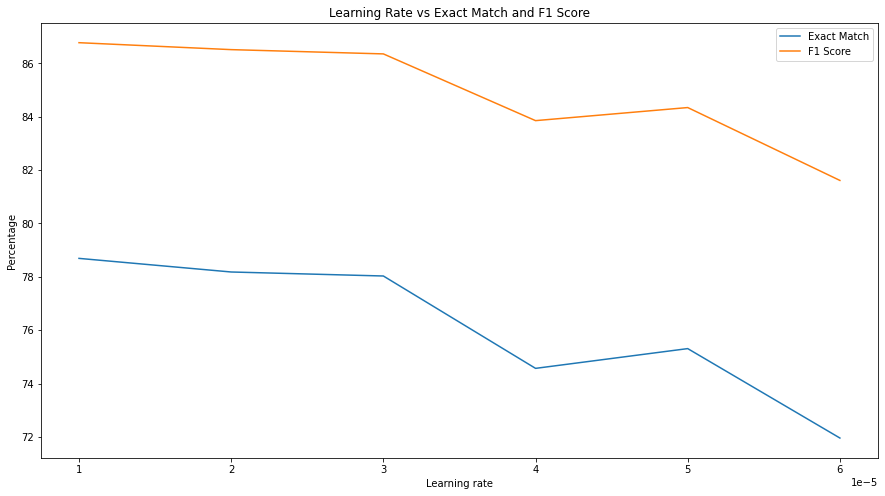

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Learning Rate vs Exact Match and F1 Score")
plt.xlabel("Learning rate")
plt.ylabel("Percentage")
plt.plot(lr, em, label = 'Exact Match')
plt.plot(lr, f1, label = 'F1 Score')
plt.legend()
plt.show()

In [ ]:
!pip install flask-ngrok 
# >> dev/null

# User Interface

A simple GUI has been developed, where a user can enter any context and question and a answer will be generated. To run the below cell, flask-ngrok needs to be imported. <br>

Whenever the below cell is run, a different link is generated. The context and the question entered in the html are sent via POST method and it is then passed as an argument in the inference model to predict the answer.

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template
from flask import request
import flask    
app = Flask(__name__, template_folder='drive/My Drive/templates')

run_with_ngrok(app)

@app.route("/")
def index():

    return render_template('index.html')  
@app.route('/', methods=['POST'])
def my_form_post():
    context = request.form['context']
    question=request.form['question']
    # plausible_answers = ["Computational complexity theory", "Computational complexity theory"]
    # input_ids, token_type_ids, _, _ = squad_features(context, question, plausible_answers[0], start_pos, tokenizer)
    prediction = inference_model(model, tokenizer, context, question, input_ids, token_type_ids)
    
    return render_template('index.html',question=question, answer=prediction)

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://4ccdb869ea23.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [08/Dec/2020 02:26:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Dec/2020 02:26:15] "GET /static/logo.png HTTP/1.1" 404 -
127.0.0.1 - - [08/Dec/2020 02:26:43] "POST / HTTP/1.1" 200 -


In [ ]:
# from google.colab.output import eval_js
# print(eval_js("google.colab.kernel.proxyPort(5000)"))